In [3]:
from tkinter import *
from PIL import ImageTk,Image
import cv2
import matplotlib.pyplot as plt

from __future__ import print_function

import time
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16


from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

from __future__ import print_function

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

from gtts import gTTS 
import speech_recognition as sr
import os 


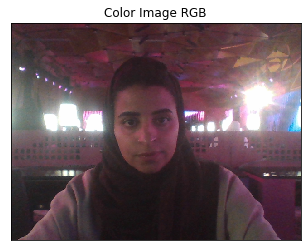

(1, 512, 512, 3)
(1, 512, 512, 3)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Start of iteration 0
Current loss value: 47216040000.0
Iteration 0 completed in 126s
Start of iteration 1


In [ ]:
root= Tk()
root.geometry("1024x600")
root.title('ART')
root.configure(width=1024, height=600,background="#3E3E3E")

capture= ImageTk.PhotoImage(Image.open("camera.png"))
capture_label = Label(image=capture)
# capture_label.pack(pady=220,padx=60)
capture_label.grid(row=0,column=0,pady=100,padx=400)

#speech
  
mytext='Hi my name is Emma I am intelligent robot artist If you want me to draw you click on button Picture '
# Language we want to use 
language = 'en'
  

myobj = gTTS(text=mytext, lang=language) 
  

myobj.save("output.mp3") 
  
# Play the converted file 
os.system("start output.mp3") 




def capture_image():
    cap = cv2.VideoCapture(0)
    if cap.isOpened():
        ret, frame = cap.read()
    else:
        ret = False
    
    img1 = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(r'C:\Users\nadaa\Python  Project\GUI\ArtPhoto\photo.png',frame)
    
    plt.imshow(img1)
    plt.title('Color Image RGB')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
     

capture_button = Button(root,text='Picture',fg="#ffffff",bg="#3E3E3E",command=capture_image)
capture_button.config(font=("Courier", 36))
capture_button.grid(row=1,column=0,pady=10,padx=60)

root.mainloop() 



#####

height = 512
width = 512

content_image_path = r'C:\Users\nadaa\Python  Project\GUI\ArtPhoto\photo.png'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
# plt.imshow(content_image)
# plt.show()
content_image


style_image_path =  r'C:\Users\nadaa\Python  Project\GUI\ArtPhoto\style.jpeg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image     


content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)


content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))


input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)


model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0



loss = backend.variable(0.)

def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
    

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)


grads = backend.gradients(loss, combination_image)


outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    

x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)


cv2.imwrite(r'C:\Users\nadaa\Python  Project\GUI\ArtPhoto\new_photo.png',x)

second=Toplevel()
second.title("Image")
# second.configure(width=1024, height=600,background="#3E3E3E")
# second.geometry("1024x600")


person_image= ImageTk.PhotoImage(Image.open(r'C:\Users\nadaa\Python  Project\GUI\ArtPhoto\new_photo.png'))
capture_label2 = Label(image=person_image,anchor=CENTER)
capture_label2.grid(row=0,column=0,pady=100,padx=400)


second.mainloop()
